In [1]:
from sklearn.cluster import KMeans
from graph_filters import graph_filtering
from scipy.io import loadmat
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami
import numpy as np
from sklearn.metrics import adjusted_rand_score as ari
from time import time
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.cluster import AgglomerativeClustering
import matplotlib as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import HDBSCAN
import bcubed
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift,estimate_bandwidth
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
import hdbscan
from sklearn.metrics import make_scorer
import openai
#from openai import OpenAI
from scipy.spatial.distance import euclidean
import os
from langchain.embeddings.openai import OpenAIEmbeddings

In [8]:
metrics_all={}

def smoothing_meanshift():
    runs = 1
    degree = 3
    metrics_sm_kmeans={}
    hyp_para={}
    for method in [
       
        'dgc'
    ]:
        print(f'{method}:')
        dataset = 'test2'#abstract' #:name your dataset here

        data = loadmat(f'data/embeddings/new_embedding.mat')
        features1 = data['x']
        labels = data['y'].reshape(-1)

        n_clusters = len(np.unique(labels))

        t0 = time()
        if method:
            features = graph_filtering(features1, method=method)
        pre_time = time() - t0
        
        metrics_sm = {'silhouettescore':[],'db_index':[],'ami': [], 'ari': [],'precision':[],'recall':[],'fscore':[]}

        for run in range(runs):
            t0 = time()
            y_pred_hyp_para=[]

            for q in np.arange(0.1,0.5,0.05):
                ibandwidth=estimate_bandwidth(features,quantile=q)#,random_state=42)
                sclustering= MeanShift(bandwidth=ibandwidth,max_iter=500)
       
                y_pred= sclustering.fit_predict(features)
                y_pred_hyp_para.append(ari(labels, y_pred))
               

            ibandwidth = estimate_bandwidth(features, quantile=0.25,random_state=42)
            msclustering= MeanShift(bandwidth=ibandwidth,max_iter=900)
            Z= msclustering.fit_predict(features)
            print(np.unique(Z))
            # Perform PCA for dimensionality reduction

            pca = PCA(n_components=2)
            features_pca = pca.fit_transform(features)
            label_dict={ 0:'architecture',1:'remote control',2:'office relocation',3:'social media'} #

            # Plot the clusters
            plt.figure(figsize=(9, 4))
            for i in range(len(np.unique(Z))):
                plt.scatter(features_pca[Z == i, 0], features_pca[Z == i, 1], label=label_dict[i])
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Hue on the left
            plt.title(f'PCA Visualization of predicted  Clusters for {method}')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.show()
            # Load the embeddings from the .mat file
            label_actual_dict={ 0:'social media',1:'office relocation',2:'remotecontroldevice',3:'architecture'} #

            embeddings = data['x']
            actual_labels = data['y'].reshape(-1)

            # Apply PCA for dimensionality reduction
            pca_actual = PCA(n_components=2)
            embeddings_pca = pca_actual.fit_transform(embeddings)

# Plot the clusters based on actual labels
            plt.figure(figsize=(9, 4))
            for label in set(actual_labels):
                indices = [i for i, l in enumerate(actual_labels) if l == label]
                plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], label=label_actual_dict[label])
            plt.legend(loc='upper right', bbox_to_anchor=(1,1))  # Hue on the left
            plt.title('PCA Visualization of Clusters (Actual Labels)')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            
            plt.show()
            metrics_sm['silhouettescore'].append(0)#silhouette_score(features, Z, metric='euclidean'))
            metrics_sm['db_index'].append(0)#davies_bouldin_score(features, Z))
            #metrics_sm['ch_index'].append(calinski_harabasz_score(features, Z))
                
            metrics_sm['ami'].append(ami(labels, Z))
            metrics_sm['ari'].append(ari(labels, Z))
            data = pd.read_csv(f'data/text/{dataset}.csv')
            text = data['text']
            cluster_centroids = []
            for cluster_label in np.unique(Z):
                cluster_points = features[Z == cluster_label]
                cluster_centroid = np.mean(cluster_points, axis=0)
                cluster_centroids.append(cluster_centroid.flatten())  # Flatten the centroid to make it 1-D
                print(cluster_centroid.shape)
        # Calculate distance between query embedding and each cluster's centroid
            query_embedding = loadmat(f'data/embeddings/social_media_1.mat')['x']
            #query_embedding = graph_filtering(query_embedding, method=method)
            print(query_embedding.shape)
            distances = [np.linalg.norm(query_embedding - centroid.reshape(-1)) for centroid in cluster_centroids]

            # Find the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            print("closest")
            print(closest_cluster)
            cdict={}
            for i in range(len(text)):  
                cdict[text[i]]=set([labels[i]])

            ldict={}
            for i in range(len(text)):  
                ldict[text[i]]=set([Z[i]])
        
            precision = bcubed.precision(cdict, ldict)
            recall = bcubed.recall(cdict, ldict)
            fscore = bcubed.fscore(precision, recall)
                
                
            metrics_sm['precision'].append(precision)
            metrics_sm['recall'].append(recall)
            metrics_sm['fscore'].append(fscore)
            print("Bcubed metric for:")
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'Fscore: {fscore}') 

            #storing resu;lt for further analysis
            data={'text':text,'ActualLabel':labels,'PredictedLabel':Z}
            pred_df=pd.DataFrame(data)
            #print(pred_df)
            pred_df.to_csv(f"data/Smoothing-meanshift/{method}/smms-{method}.csv")
        

                #metrics_sm['time'].append(pre_time + time() - t0)
        results = {
            'mean': {k: (np.mean(v)).round(4) for k, v in metrics_sm.items()},
            'std': {k: (np.std(v)).round(4) for k, v in metrics_sm.items()}
        }
            
        means = results['mean']
        stds = results['std']
        means_std=[means,stds]
            #print(f'\tmeans: ', means['silhouettescore'],means['db_index'],means['ch_index'],means['ami'], means['ari'], sep='&')
            #print(f'\tstds: ', stds['silhouettescore'],stds['db_index'],stds['ch_index'],stds['ami'], stds['ari'], sep='&')
        metrics_sm_kmeans[method]=means
        #hyp_para
        hyp_para[method]=y_pred_hyp_para

    #metrics_all['smoothing_kmeans']=metrics_sm_kmeans
    #print(hyp_para)
    x_values = np.arange(0.1,0.5,0.05) #* len(y_preds)
    for key, values in hyp_para.items():
        plt.plot(x_values[:len(values)], values, label=key)
    
    plt.xlabel('Quantile')
    plt.ylabel('Adjusted Rand Index')
    plt.title('MeanShift Clustering Predictions for Different Quantile Values and differnt polynomial filters')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()   
    return metrics_sm_kmeans

dgc:
[0 1 2 3]


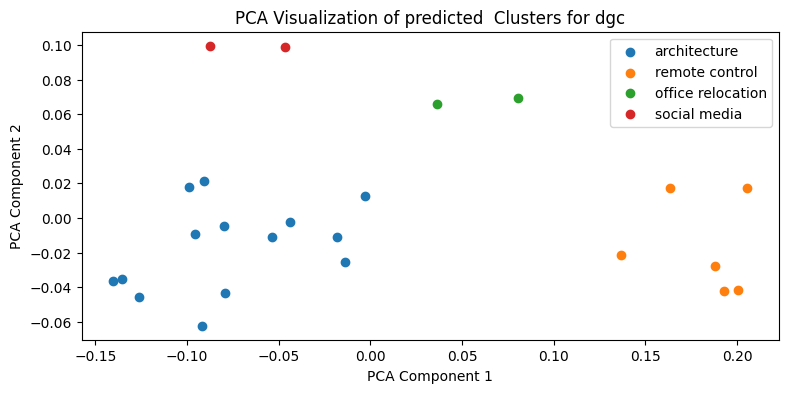

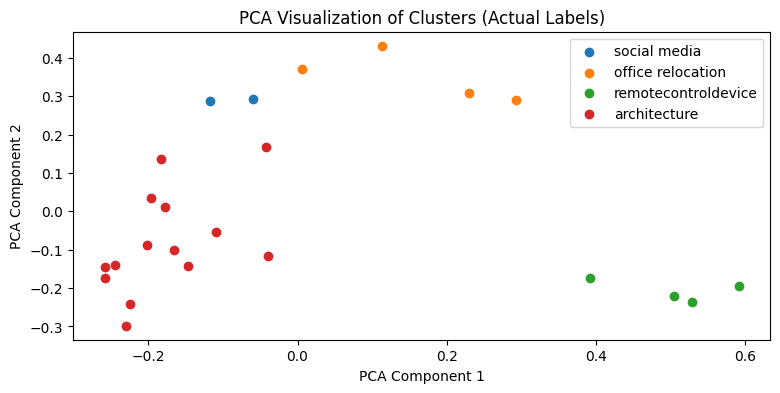

(3072,)
(3072,)
(3072,)
(3072,)
(1, 3072)
closest
3
Bcubed metric for:
Precision: 0.9166666666666666
Recall: 0.8888888888888888
Fscore: 0.9025641025641026


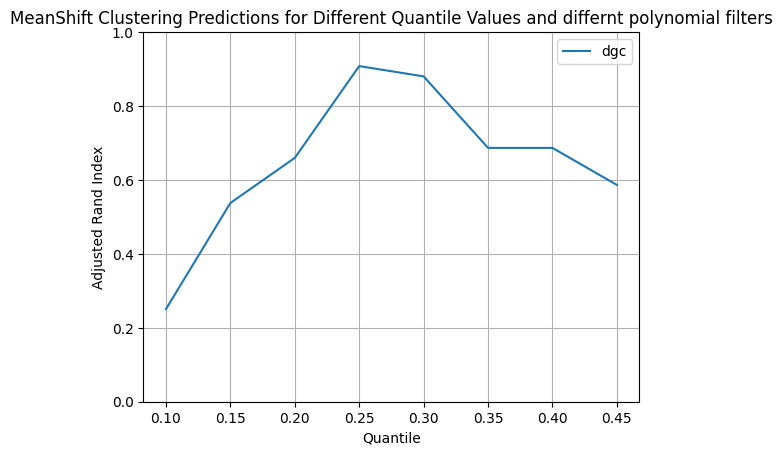

In [9]:
eval_sm_ms= smoothing_meanshift()